## Import necessary packages 

Use a Python package to grab USGS data. Need to install the package beforehand. See details her: https://github.com/USGS-python/dataretrieval

In [119]:
import dataretrieval.nwis as nwis
import pandas as pd
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('science')
!pip install dc_stat_think
import dc_stat_think as dcst
from scipy.optimize import curve_fit

## Define a funcation for each data download

First, let's define a function to retrieve data so that we don't need to write the same scripts for different sites. 

In [128]:
start_date = '2019-01-01'
end_date = '2022-12-31'
site_no = '06926510'

df1 = nwis.get_record(sites=site_no, service='dv', start=start_date, end = end_date, parameterCd = '00060')
df1 = df1.drop(['site_no','00060_Mean_cd'],axis=1)
df1 = df1.rename(columns={"00060_Mean": "discharge"})

df2 = nwis.get_record(sites=site_no, service='dv', start=start_date, end = end_date, parameterCd = '00065')
df2 = df2.rename(columns={"00065_Observation at 08:00": "water_depth"})
df2 = df2.drop(['site_no','00065_Observation at 08:00_cd'],axis=1)

df = pd.concat([df1,df2], axis=1)
df = df.reset_index(level=0)
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [129]:
def powlaw(x, a, b) :
    return a * np.power(x, b)

percentiles of Q (cfs) are: 
[ 1240.  3260. 14900. 31400. 48060.]
percentiles of stage (ft) are: 
[ 1.47581959  2.82452373  7.83689556 12.92862655 17.20641121]
----------------


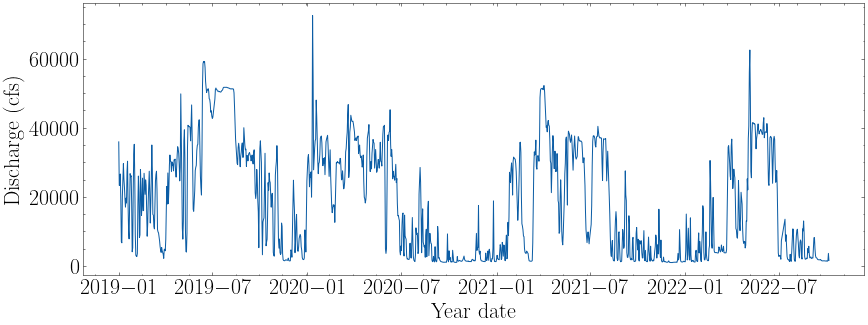

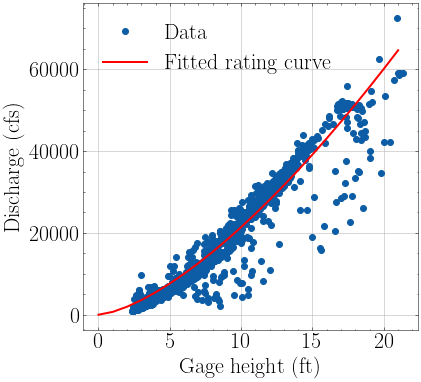

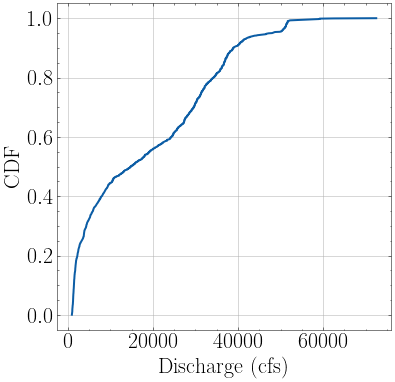

In [144]:
fig0 = plt.figure(figsize=(14,5))
plt.plot(df['datetime'],df['discharge'])
plt.xlabel('Year date')
plt.ylabel('Discharge (cfs)')
#plt.savefig('discharge.pdf')


fig1 = plt.figure(figsize=(6,6))
plt.plot(df['water_depth'],df['discharge'],'o',label='Data')
plt.xlabel('Gage height (ft)')
plt.ylabel('Discharge (cfs)')
# ax2.set_ylim((0,10000))
# discharge = df.sort_values('discharge')['discharge'].to_numpy()
x, y = dcst.ecdf(discharge)


popt, pcov = curve_fit(powlaw, df['water_depth'].to_numpy(), df['discharge'].to_numpy())
xfit = np.arange(0,max(df['water_depth'].to_numpy()))
plt.plot(xfit, popt[0] * np.power(xfit,popt[1]),'r',linewidth=2,label='Fitted rating curve')
plt.grid(True)
plt.legend()
#plt.savefig('rating_curve.pdf')


fig2 = plt.figure(figsize = (6,6))
plt.plot(x,y,linewidth=2)
# plt.xlim((1,25000))
plt.xlabel('Discharge (cfs)')
plt.ylabel('CDF')
plt.grid(True)
Q = np.percentile(x, [5, 25, 50, 75, 95])
#plt.savefig('discharge_CDF.pdf')
print('percentiles of Q (cfs) are: ')
print(Q)
H = np.exp(np.log(Q/popt[0])/popt[1])
print('percentiles of stage (ft) are: ')
print(H)
print('----------------')

In [134]:
pcov

array([[ 9.03137452e+02, -4.91696845e-01],
       [-4.91696845e-01,  2.70797192e-04]])